In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torchvision import datasets,transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(24),transforms.Resize(28),transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])

In [4]:
train_set = datasets.MNIST('../data',train=True,download=True,transform=train_transforms)
test_set = datasets.MNIST('../data',train=False,download=True,transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 312402026.12it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 9469644.61it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 123240575.88it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15375729.43it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
batch_size  = 64
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [6]:

def show_imgs(imgs,labels):
  fig = plt.figure(figsize=(5,5))
  axs = fig.subplots(4,7)
  for i in range(4):
    for j in range(7):
      axs[i][j].imshow(imgs[i+j].reshape(28,28),cmap='gray')
      axs[i][j].set_xlabel(labels[i+j].item())
      axs[i][j].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False,right=False)
  plt.show()






In [7]:
imgs,lbls = next(iter(train_loader))

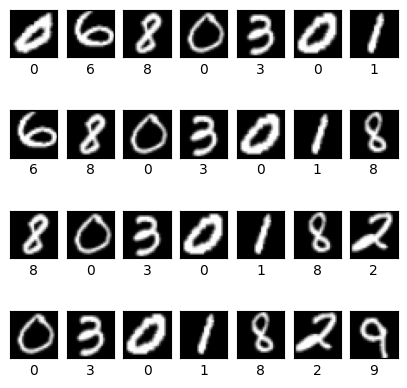

In [8]:
show_imgs(imgs,lbls)

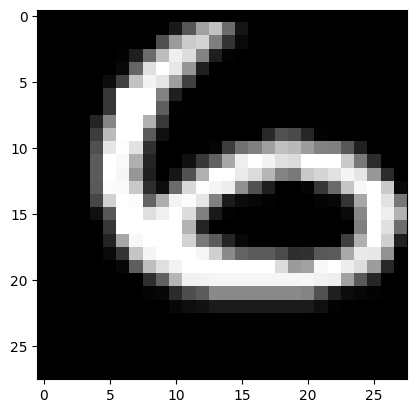

In [9]:
plt.imshow(imgs[1].reshape(28,28),cmap='gray')


In [10]:
# class MNet(nn.Module):
#   def __init__(self):
#     super(MNet,self).__init__()
#     self.conv1 = nn.Conv2d(1,64,3)
#     self.conv2 = nn.Conv2d(64,128,1)
#     self.pool1 = nn.MaxPool2d(2,2)
#     self.conv3 = nn.Conv2d(128,64,1)
#     self.bt_nm = nn.BatchNorm2d(64)
#     self.conv4 = nn.Conv2d(64,32,1)
#     self.gav1 = nn.AvgPool2d(13)
#     self.conv5 = nn.Conv2d(32,10,1)

#   def forward(self,x):
#     x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#     x = self.bt_nm(F.relu(self.conv3(x)))
#     x = F.relu(self.conv5(self.gav1(F.relu(self.conv4(x)))))
#     x = x.view(-1,10)
#     return F.log_softmax(x)


In [11]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = MNet().to(device)
# summary(model, input_size=(1, 28, 28))

In [12]:
!pip install tqdm

In [13]:

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


In [14]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [15]:
# model = MNet().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# # New Line
# criterion = nn.CrossEntropyLoss(reduction="sum")
# num_epochs = 20
# for epoch in range(1, num_epochs+1):
#   print(f'Epoch {epoch}')
#   train(model, device, train_loader, optimizer, criterion)
#   test(model, device, train_loader, criterion)
#   scheduler.step()

In [16]:
# class MNet2(nn.Module):
#   def __init__(self):
#     super(MNet2,self).__init__()
#     self.conv1 = nn.Conv2d(1,32,3)
#     self.conv2 = nn.Conv2d(32,36,3)
#     self.pool1 = nn.MaxPool2d(2,2)
#     self.conv3 = nn.Conv2d(36,24,3)
#     self.bt_nm = nn.BatchNorm2d(24)
#     self.conv4 = nn.Conv2d(24,16,1)
#     self.conv5 = nn.Conv2d(16,10,1)
#     self.gav1 = nn.AvgPool2d(10)

#   def forward(self,x):
#     x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#     x = self.bt_nm(F.relu(self.conv3(x)))
#     x = self.gav1(F.relu(self.conv5(F.relu(self.conv4(x)))))
#     x = x.view(-1,10)
#     return F.log_softmax(x,dim=1)

In [17]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = MNet2().to(device)
# summary(model, input_size=(1, 28, 28))


In [18]:
# model = MNet2().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# # New Line
# criterion = nn.CrossEntropyLoss(reduction="sum")
# num_epochs = 20
# for epoch in range(1, num_epochs+1):
#   print(f'Epoch {epoch}')
#   train(model, device, train_loader, optimizer, criterion)
#   test(model, device, train_loader, criterion)
#   scheduler.step()

In [24]:
class MNet3(nn.Module):
  def __init__(self):
    super(MNet3,self).__init__()
    self.conv1 = nn.Conv2d(1,32,3)
    self.conv2 = nn.Conv2d(32,28,3)
    self.bt_nm1 = nn.BatchNorm2d(28)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(28,24,3)
    self.conv4 = nn.Conv2d(24,20,3)
    self.bt_nm = nn.BatchNorm2d(20)
    self.drop2 = nn.Dropout(0.15)
    self.conv5 = nn.Conv2d(20,16,1)
    self.conv6 = nn.Conv2d(16,10,1)
    self.gav1 = nn.AvgPool2d(8)

  def forward(self,x):
    x = self.pool1(self.bt_nm1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.drop2(self.bt_nm(F.relu(self.conv4((F.relu(self.conv3(x)))))))
    x = self.gav1(F.relu(self.conv6((F.relu(self.conv5(x))))))
    x = x.view(-1,10)
    return F.log_softmax(x,dim=1)

In [25]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MNet3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 28, 24, 24]           8,092
       BatchNorm2d-3           [-1, 28, 24, 24]              56
         MaxPool2d-4           [-1, 28, 12, 12]               0
            Conv2d-5           [-1, 24, 10, 10]           6,072
            Conv2d-6             [-1, 20, 8, 8]           4,340
       BatchNorm2d-7             [-1, 20, 8, 8]              40
           Dropout-8             [-1, 20, 8, 8]               0
            Conv2d-9             [-1, 16, 8, 8]             336
           Conv2d-10             [-1, 10, 8, 8]             170
        AvgPool2d-11             [-1, 10, 1, 1]               0
Total params: 19,426
Trainable params: 19,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [26]:

model = MNet3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss(reduction="sum")
num_epochs = 20
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=4.4170 Batch_id=937 Accuracy=83.25: 100%|██████████| 938/938 [00:29<00:00, 32.22it/s]


Test set: Average loss: 0.2460, Accuracy: 55478/60000 (92.46%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=3.8180 Batch_id=937 Accuracy=94.19: 100%|██████████| 938/938 [00:30<00:00, 30.57it/s]


Test set: Average loss: 0.1473, Accuracy: 57511/60000 (95.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.4788 Batch_id=937 Accuracy=95.93: 100%|██████████| 938/938 [00:30<00:00, 30.43it/s]


Test set: Average loss: 0.0730, Accuracy: 58784/60000 (97.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.7154 Batch_id=937 Accuracy=96.50: 100%|██████████| 938/938 [00:29<00:00, 31.77it/s]


Test set: Average loss: 0.1404, Accuracy: 57655/60000 (96.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=5.9756 Batch_id=937 Accuracy=96.98: 100%|██████████| 938/938 [00:30<00:00, 31.26it/s]


Test set: Average loss: 0.0834, Accuracy: 58536/60000 (97.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=5.8467 Batch_id=937 Accuracy=96.97: 100%|██████████| 938/938 [00:29<00:00, 31.29it/s]


Test set: Average loss: 0.0867, Accuracy: 58495/60000 (97.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.4844 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:29<00:00, 31.98it/s]


Test set: Average loss: 0.0839, Accuracy: 58614/60000 (97.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1707 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:30<00:00, 31.13it/s]


Test set: Average loss: 0.0465, Accuracy: 59138/60000 (98.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=1.6927 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:29<00:00, 31.58it/s]


Test set: Average loss: 0.0528, Accuracy: 59096/60000 (98.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=11.2724 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:29<00:00, 32.02it/s]


Test set: Average loss: 0.1192, Accuracy: 58218/60000 (97.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0739 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:29<00:00, 31.37it/s]


Test set: Average loss: 0.0233, Accuracy: 59577/60000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0735 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:29<00:00, 32.22it/s]


Test set: Average loss: 0.0212, Accuracy: 59605/60000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.2984 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:29<00:00, 31.93it/s]


Test set: Average loss: 0.0192, Accuracy: 59656/60000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.2069 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:28<00:00, 32.35it/s]


Test set: Average loss: 0.0185, Accuracy: 59670/60000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.2332 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:29<00:00, 32.21it/s]


Test set: Average loss: 0.0186, Accuracy: 59660/60000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.2079 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:29<00:00, 31.61it/s]


Test set: Average loss: 0.0163, Accuracy: 59713/60000 (99.52%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.1193 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:29<00:00, 31.67it/s]


Test set: Average loss: 0.0162, Accuracy: 59698/60000 (99.50%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0462 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:30<00:00, 30.57it/s]


Test set: Average loss: 0.0166, Accuracy: 59713/60000 (99.52%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.1719 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:29<00:00, 31.91it/s]


Test set: Average loss: 0.0156, Accuracy: 59715/60000 (99.53%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0206 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:29<00:00, 31.59it/s]


Test set: Average loss: 0.0156, Accuracy: 59715/60000 (99.53%)

Adjusting learning rate of group 0 to 1.0000e-04.
